In [1]:
############### Plot Correlations as Heat Maps ##################
# The purpose of this notebook is to plot the correlations
# between SSC and waves, currents, bed shear stress as heat maps
# in the sections rather than a line plot. Once this works, the 
# code will be added into the OG script that does all of this.
#
# Notes:
# - 
#
#################################################################

In [150]:
# Load in the packages
import numpy as np
import xarray as xr
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import cmocean 
from scipy.stats import pearsonr
import matplotlib.ticker as tick
from matplotlib import ticker
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
crs = ccrs.PlateCarree()
#Cartopy
land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                edgecolor='face',
                                facecolor=cfeature.COLORS['land'])

In [3]:
# Load in the grid
grid = xr.open_dataset('/Users/brun1463/Desktop/Research_Lab/Kaktovik_Alaska_2019/Code/Grids/KakAKgrd_shelf_big010_smooth006.nc')


In [54]:
# Pull out shapes
eta_rho_len = len(grid.eta_rho)
xi_rho_len = len(grid.xi_rho)

# Make land mask
temp_mask = grid.mask_rho.values
temp_mask = np.where(temp_mask==0, np.nan, temp_mask)

In [136]:
# Load in nan masks 
mask_rho_nan = xr.open_dataset('/Users/brun1463/Desktop/Research_Lab/Kaktovik_Alaska_2019/Code/Nudge_masks/nudge_mask_rho_ones_nans.nc')
mask_rho_zeros = xr.open_dataset('/Users/brun1463/Desktop/Research_Lab/Kaktovik_Alaska_2019/Code/Nudge_masks/nudge_mask_rho_zeros_ones.nc')

In [5]:
# Load in the data
# Aggregated 
timeseries_agg = xr.open_dataset('/Users/brun1463/Desktop/Research_Lab/Beaufort_Shelf_Rivers_proj_002/Figure_data/timeseries_ssc_hwave_curmag_bsrt_by_section_agg.nc')
# Unaggregated
timeseries_unag = xr.open_dataset('/Users/brun1463/Desktop/Research_Lab/Beaufort_Shelf_Rivers_proj_002/Figure_data/timeseries_ssc_hwave_curmag_bsrt_by_section_unag.nc')

In [7]:
timeseries_agg

<xarray.Dataset>
Dimensions:                      (ocean_time: 781, section: 13, wave_time: 3001)
Coordinates:
  * ocean_time                   (ocean_time) datetime64[ns] 2020-07-01T01:00...
  * wave_time                    (wave_time) float64 6.469e+08 ... 6.577e+08
  * section                      (section) int64 1 2 3 4 5 6 7 8 9 10 11 12 13
Data variables:
    ssc_avg_by_section           (ocean_time, section) float64 ...
    Hwave_avg_by_section         (wave_time, section) float64 ...
    cur_mag_1mab_avg_by_section  (ocean_time, section) float64 ...
    bstr_avg_by_section          (ocean_time, section) float64 ...
Attributes:
    description:  Time series of total depth-integrated SSC, Hwave, current m...

In [8]:
timeseries_unag

<xarray.Dataset>
Dimensions:                      (ocean_time: 757, section: 13, wave_time: 3001)
Coordinates:
  * ocean_time                   (ocean_time) datetime64[ns] 2020-07-01T01:00...
  * wave_time                    (wave_time) float64 6.469e+08 ... 6.577e+08
  * section                      (section) int64 1 2 3 4 5 6 7 8 9 10 11 12 13
Data variables:
    ssc_avg_by_section           (ocean_time, section) float64 ...
    Hwave_avg_by_section         (wave_time, section) float64 ...
    cur_mag_1mab_avg_by_section  (ocean_time, section) float64 ...
    bstr_avg_by_section          (ocean_time, section) float64 ...
Attributes:
    description:  Time series of total depth-integrated SSC, Hwave, current m...

In [20]:
timeseries_agg.ocean_time[0:5].values

array(['2020-07-01T01:00:00.000000000', '2020-07-01T05:00:00.000000000',
       '2020-07-01T09:00:00.000000000', '2020-07-01T13:00:00.000000000',
       '2020-07-01T17:00:00.000000000'], dtype='datetime64[ns]')

In [189]:
timeseries_agg.wave_time

<xarray.DataArray 'wave_time' (wave_time: 3001)>
array(['2020-07-01T01:00:00.000000000', '2020-07-01T02:00:00.000000000',
       '2020-07-01T03:00:00.000000000', ..., '2020-11-02T23:00:00.000000000',
       '2020-11-03T00:00:00.000000000', '2020-11-03T01:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * wave_time  (wave_time) datetime64[ns] 2020-07-01T01:00:00 ... 2020-11-03T...

In [ ]:
# Prep wave time for correlations
# Convert the times to datetimes
wave_time_agg = pd.to_datetime(timeseries_agg.wave_time.values+86400, origin=datetime(1999,12,31), unit='s')
wave_time_unag = pd.to_datetime(timeseries_unag.wave_time.values+86400, origin=datetime(1999,12,31), unit='s')


In [163]:
# Print the times to compare 
print(timeseries_agg.ocean_time[0:5].values)
print(wave_time_agg[0:5].values)
print(timeseries_agg.ocean_time[-5:-1].values)
print(wave_time_agg[-5:-1].values)

['2020-07-01T01:00:00.000000000' '2020-07-01T05:00:00.000000000'
 '2020-07-01T09:00:00.000000000' '2020-07-01T13:00:00.000000000'
 '2020-07-01T17:00:00.000000000']
['2020-07-01T01:00:00.000000000' '2020-07-01T02:00:00.000000000'
 '2020-07-01T03:00:00.000000000' '2020-07-01T04:00:00.000000000'
 '2020-07-01T05:00:00.000000000']
['2020-11-07T09:00:00.000000000' '2020-11-07T13:00:00.000000000'
 '2020-11-07T17:00:00.000000000' '2020-11-07T21:00:00.000000000']
['2020-11-02T21:00:00.000000000' '2020-11-02T22:00:00.000000000'
 '2020-11-02T23:00:00.000000000' '2020-11-03T00:00:00.000000000']


In [165]:
# Add into arrays
timeseries_agg['wave_time'] = wave_time_agg
timeseries_unag['wave_time'] = wave_time_unag

In [166]:
# Resample onto the frequency of the output/other data
# Aggregated
hwave_agg = timeseries_agg.Hwave_avg_by_section.resample(wave_time='4h').mean()
print('Hwave_avg_by_section len: ', len(timeseries_agg.Hwave_avg_by_section))
print('hwave_agg len: ', len(hwave_agg))

# Unaggregated
hwave_unag = timeseries_unag.Hwave_avg_by_section.resample(wave_time='4h').mean()
print('Hwave_avg_by_section len: ', len(timeseries_unag.Hwave_avg_by_section))
print('hwave_unag len: ', len(hwave_unag))


Hwave_avg_by_section len:  3001
hwave_agg len:  751
Hwave_avg_by_section len:  3001
hwave_unag len:  751


In [11]:
# Make a function that takes a given dataset and calculate the correlations for each section
def get_correlations(x_data, y_data):
    """
    The purpose of this function is to take two variables that 
    have dimensions [time, section] and calculate the correlations 
    in each section. 

    Inputs:
    - x_data: Data for correlation [time, section]
    - y_data: Data for correlation [time, section], should have same shape as x_data

    Outputs:

    """

    # Get the number of sections 
    num_sections = len(x_data[0,:])

    # Make empty arrays to hold the correlations and p values for each section
    corr = np.empty((num_sections))
    p_val = np.empty((num_sections))

    # Loop through the sections and get the correlations
    for s in range(num_sections):
        # Get the correlation and p value
        corr[s], p_val[s] = pearsonr(x_data[:,s], y_data[:,s])

    # Return these correlations and p values
    return(corr, p_val)


In [167]:
# Now call this function for each set of variables 
# SSC and Hwave
r2_ssc_hwave_agg, p_ssc_hwave_agg = get_correlations(timeseries_agg.ssc_avg_by_section[:748,:], hwave_agg[:748,:])
r2_ssc_hwave_unag, p_ssc_hwave_unag = get_correlations(timeseries_unag.ssc_avg_by_section[:748,:], hwave_unag[:748,:])
# SSC and cur mag 1 m above seafloor
r2_ssc_botcurmag_agg, p_ssc_botcurmag_agg = get_correlations(timeseries_agg.ssc_avg_by_section[:748,:], timeseries_agg.cur_mag_1mab_avg_by_section[:748,:])
r2_ssc_botcurmag_unag, p_ssc_botcurmag_unag = get_correlations(timeseries_unag.ssc_avg_by_section[:748,:], timeseries_unag.cur_mag_1mab_avg_by_section[:748,:])
# SSC and bed shear stress
r2_ssc_bstr_agg, p_ssc_bstr_agg = get_correlations(timeseries_agg.ssc_avg_by_section[:748,:], timeseries_agg.bstr_avg_by_section[:748,:])
r2_ssc_bstr_unag, p_ssc_bstr_unag = get_correlations(timeseries_unag.ssc_avg_by_section[:748,:], timeseries_unag.bstr_avg_by_section[:748,:])

In [168]:
print(r2_ssc_hwave_agg)
print(r2_ssc_hwave_unag)
print(r2_ssc_botcurmag_agg)
print(r2_ssc_botcurmag_unag)
print(r2_ssc_bstr_agg)
print(r2_ssc_bstr_unag)

[0.90806517 0.89813482 0.89321397 0.87641762 0.80083223 0.73214617
 0.6150798  0.65480849 0.34252715 0.40639825 0.37068755 0.32666866
 0.22191267]
[0.90420606 0.9031201  0.89342721 0.8775117  0.80032165 0.73114389
 0.6144011  0.64859659 0.34750225 0.4061775  0.37285252 0.32046337
 0.22688763]
[0.61426482 0.60870754 0.45340033 0.51425522 0.53998497 0.61434266
 0.59722991 0.61665431 0.25578248 0.77707527 0.69769097 0.76957596
 0.62472006]
[0.6174422  0.6016902  0.45425247 0.51874707 0.54239204 0.6171086
 0.60629271 0.61436965 0.26269547 0.7811824  0.69315529 0.76231599
 0.62902691]
[0.91358212 0.91460213 0.89527445 0.90582303 0.84144531 0.79539793
 0.7520861  0.79517508 0.35671781 0.77783205 0.69045764 0.74532579
 0.51381798]
[0.92374182 0.9202238  0.89493261 0.90684444 0.84115976 0.79554865
 0.75357226 0.78827712 0.3657407  0.77702592 0.68533164 0.73941721
 0.51751999]


In [169]:
# ------ Masking -----
# Make functions to help with masking 
# Make masks to isolate each region, starting with breaking things up by depth 
# Make a function to mask the data
def masked_array(data, threshold):
    """
    This function takes an array and masks all values that are less
    than a certain given threshold. The functions returns 1 for areas that meet 
    the condition and 0 for areas that don't. So areas where the array is less
    than the threshold get returned as 1 and areas greater than the threshold
    are returned as 0. This function maintains the shape of the array.
    
    """
    return (data <= threshold).astype(int)

In [170]:
# Make a function to mask the data but that takes two thresholds
def masked_array_lowhigh_2dloop(data, lower, upper):
    """
    This function takes an array and masks all values that are less
    than a certain given threshold. The functions returns 1 for areas that meet 
    the condition and 0 for areas that don't. So areas where the array is less
    than the threshold get returned as 1 and areas greater than the threshold
    are returned as 0. This function maintains the shape of the array.
    
    """
    mask_tmp = np.empty_like((data))
    
    # Loop through dimension 1
    for i in range(len(data[:,0])):
        # Loop through dimension 2
        for j in range(len(data[0,:])):
            # Compare against threshold 
            value = data[i,j]
            if lower < value <= upper:
                mask_tmp[i,j] = 1
            else:
                mask_tmp[i,j] = 0
    
    
    return (mask_tmp).astype(int)

In [171]:
# Make a function to mask the data - higher
def masked_array_higher(data, threshold):
    """
    This function takes an array and masks all values that are less
    than a certain given threshold. The functions returns 1 for areas that meet 
    the condition and 0 for areas that don't. So areas where the array is less
    than the threshold get returned as 1 and areas greater than the threshold
    are returned as 0. This function maintains the shape of the array.
    
    """
    return (data >= threshold).astype(int)

In [172]:
# Make the masks for each section 
# Make the masks to partition the seabed into different regions 

# Call the function to make the mask
# Leave in the region that is nudged/past the slope since we will need 
# to put sediment there regardless

# 0 - 10 m 
h_masked1 = grid.h.copy()
mask_0_10m_rho = masked_array_lowhigh_2dloop(h_masked1, 0, 10)

# 10 - 30 m
h_masked2 = grid.h.copy()
mask_10_30m_rho = masked_array_lowhigh_2dloop(h_masked2, 10, 30)

# 30 - 60 m
h_masked3 = grid.h.copy()
mask_30_60m_rho = masked_array_lowhigh_2dloop(h_masked3, 30, 60)

# > 60 m 
h_masked4 = grid.h.copy()
mask_60_end_rho = masked_array_lowhigh_2dloop(h_masked4, 60, 2200)


# Partition the seabed into the different regions 

# Make the nearshore sections 
mask_0_10m_rho_plot2 = mask_0_10m_rho.copy()
idx_ones_0_10m2 = np.where(mask_0_10m_rho_plot2 == 1)
# Set everywhere it is 1 equal to 2 
#mask_0_10m_rho_plot2[idx_ones_0_10m2] = 2
# Make an empty list to hold the indices for center
idx_ones_0_10m_far_left_etas = []
idx_ones_0_10m_far_left_xis = []
idx_ones_0_10m_center_left_etas = []
idx_ones_0_10m_center_left_xis = []
idx_ones_0_10m_center_right_etas = []
idx_ones_0_10m_center_right_xis = []
idx_ones_0_10m_far_right_etas = []
idx_ones_0_10m_far_right_xis = []
# Loop through these indices and find where they are in certain ranges
for i in range(len(idx_ones_0_10m2[0])):
    # Pull out the eta and the xi
    eta_tmp = idx_ones_0_10m2[0][i]
    xi_tmp = idx_ones_0_10m2[1][i]
    # Check if this is in the far left range
    if xi_tmp < 186:
        idx_ones_0_10m_far_left_etas.append(eta_tmp)
        idx_ones_0_10m_far_left_xis.append(xi_tmp)
    # Check if this is in the center left range
    elif 186 <= xi_tmp < 320:
        #print('xi_tmp: ', xi_tmp)
        #input('press enter to continue...')
        idx_ones_0_10m_center_left_etas.append(eta_tmp)
        idx_ones_0_10m_center_left_xis.append(xi_tmp)
    # Check if this is in the center right range
    elif 320 <= xi_tmp < 466:
        #print('xi_tmp: ', xi_tmp)
        #input('press enter to continue...')
        idx_ones_0_10m_center_right_etas.append(eta_tmp)
        idx_ones_0_10m_center_right_xis.append(xi_tmp)
        # Check if this is in the far right range
    elif xi_tmp >= 466:
        #print('xi_tmp: ', xi_tmp)
        #input('press enter to continue...')
        idx_ones_0_10m_far_right_etas.append(eta_tmp)
        idx_ones_0_10m_far_right_xis.append(xi_tmp)

# Make this 3 for center and 4 for right
mask_0_10m_rho_plot2[idx_ones_0_10m_far_left_etas[:],idx_ones_0_10m_far_left_xis[:]] = 2
mask_0_10m_rho_plot2[idx_ones_0_10m_center_left_etas[:],idx_ones_0_10m_center_left_xis[:]] = 3
mask_0_10m_rho_plot2[idx_ones_0_10m_center_right_etas[:],idx_ones_0_10m_center_right_xis[:]] = 4
mask_0_10m_rho_plot2[idx_ones_0_10m_far_right_etas[:],idx_ones_0_10m_far_right_xis[:]] = 5



# Make the middle sections 
mask_10_30m_rho_plot2 = mask_10_30m_rho.copy()
idx_ones_10_30m2 = np.where(mask_10_30m_rho_plot2 == 1)
# Set everything in here equal to 5 
#mask_10_30m_rho_plot2[idx_ones_10_30m2] = 5
# Make an empty list to hold the indices for center
idx_ones_10_30m_far_left_etas = []
idx_ones_10_30m_far_left_xis = []
idx_ones_10_30m_center_left_etas = []
idx_ones_10_30m_center_left_xis = []
idx_ones_10_30m_center_right_etas = []
idx_ones_10_30m_center_right_xis = []
idx_ones_10_30m_far_right_etas = []
idx_ones_10_30m_far_right_xis = []
# Loop through these indices and find where they are in certain ranges
for i in range(len(idx_ones_10_30m2[0])):
    # Pull out the eta and the xi
    eta_tmp = idx_ones_10_30m2[0][i]
    xi_tmp = idx_ones_10_30m2[1][i]
    # Check if this is in the far left range
    if xi_tmp < 186:
        idx_ones_10_30m_far_left_etas.append(eta_tmp)
        idx_ones_10_30m_far_left_xis.append(xi_tmp)
    # Check if this is in the center left range
    if 186 <= xi_tmp < 320:
        #print('xi_tmp: ', xi_tmp)
        #input('press enter to continue...')
        idx_ones_10_30m_center_left_etas.append(eta_tmp)
        idx_ones_10_30m_center_left_xis.append(xi_tmp)
    # Check if this is in the center right range
    if 320 <= xi_tmp < 466:
        #print('xi_tmp: ', xi_tmp)
        #input('press enter to continue...')
        idx_ones_10_30m_center_right_etas.append(eta_tmp)
        idx_ones_10_30m_center_right_xis.append(xi_tmp)
    # Check if this is in the far right range
    if xi_tmp >= 466:
        #print('xi_tmp: ', xi_tmp)
        #input('press enter to continue...')
        idx_ones_10_30m_far_right_etas.append(eta_tmp)
        idx_ones_10_30m_far_right_xis.append(xi_tmp)
# Make this 6 and 7 for the center and right 
mask_10_30m_rho_plot2[idx_ones_10_30m_far_left_etas[:],idx_ones_10_30m_far_left_xis[:]] = 6
mask_10_30m_rho_plot2[idx_ones_10_30m_center_left_etas[:],idx_ones_10_30m_center_left_xis[:]] = 7
mask_10_30m_rho_plot2[idx_ones_10_30m_center_right_etas[:],idx_ones_10_30m_center_right_xis[:]] = 8
mask_10_30m_rho_plot2[idx_ones_10_30m_far_right_etas[:],idx_ones_10_30m_far_right_xis[:]] = 9



# Make the outer sections
mask_30_60m_rho_plot2 = mask_30_60m_rho.copy()
idx_ones_30_60m2 = np.where(mask_30_60m_rho_plot2 == 1)
# Set everything in here equal to 8
#mask_30_60m_rho_plot2[idx_ones_30_60m2] = 8
# Make an empty list to hold the indices for center
idx_ones_30_60m_far_left_etas = []
idx_ones_30_60m_far_left_xis = []
idx_ones_30_60m_center_left_etas = []
idx_ones_30_60m_center_left_xis = []
idx_ones_30_60m_center_right_etas = []
idx_ones_30_60m_center_right_xis = []
idx_ones_30_60m_far_right_etas = []
idx_ones_30_60m_far_right_xis = []
# Loop through these indices and find where they are in certain ranges
for i in range(len(idx_ones_30_60m2[0])):
    # Pull out the eta and the xi
    eta_tmp = idx_ones_30_60m2[0][i]
    xi_tmp = idx_ones_30_60m2[1][i]
    # Check if this is in the far left range
    if xi_tmp < 186:
        idx_ones_30_60m_far_left_etas.append(eta_tmp)
        idx_ones_30_60m_far_left_xis.append(xi_tmp)
    # Check if this is in the center left range
    if 186 <= xi_tmp < 320:
        #print('xi_tmp: ', xi_tmp)
        #input('press enter to continue...')
        idx_ones_30_60m_center_left_etas.append(eta_tmp)
        idx_ones_30_60m_center_left_xis.append(xi_tmp)
    # Check if this is in the center right range
    if 320 <= xi_tmp < 466:
        #print('xi_tmp: ', xi_tmp)
        #input('press enter to continue...')
        idx_ones_30_60m_center_right_etas.append(eta_tmp)
        idx_ones_30_60m_center_right_xis.append(xi_tmp)
    # Check if this is in the far right range
    if xi_tmp >= 466:
        #print('xi_tmp: ', xi_tmp)
        #input('press enter to continue...')
        idx_ones_30_60m_far_right_etas.append(eta_tmp)
        idx_ones_30_60m_far_right_xis.append(xi_tmp)
# Make this 6 and 7 for the center and right 
mask_30_60m_rho_plot2[idx_ones_30_60m_far_left_etas[:],idx_ones_30_60m_far_left_xis[:]] = 10
mask_30_60m_rho_plot2[idx_ones_30_60m_center_left_etas[:],idx_ones_30_60m_center_left_xis[:]] = 11
mask_30_60m_rho_plot2[idx_ones_30_60m_center_right_etas[:],idx_ones_30_60m_center_right_xis[:]] = 12
mask_30_60m_rho_plot2[idx_ones_30_60m_far_right_etas[:],idx_ones_30_60m_far_right_xis[:]] = 13



# Make the outest section
mask_60_end_rho_plot2 = mask_60_end_rho.copy()
idx_ones_60_end2 = np.where(mask_60_end_rho_plot2 == 1)
# Set everything in here equal to 8
mask_60_end_rho_plot2[idx_ones_60_end2] = 14

# Add in the nudged sections to the last group = 14
# Set the number of cells in the sponge on each open boundary
c_west = 36
c_north = 45
c_east = 36
# Make these regions 14
mask_0_10m_rho_plot2[:,:c_west] = 14
mask_0_10m_rho_plot2[:,-c_west:] = 14
mask_10_30m_rho_plot2[:,:c_west] = 14
mask_10_30m_rho_plot2[:,-c_west:] = 14
mask_30_60m_rho_plot2[:,:c_west] = 14
mask_30_60m_rho_plot2[:,-c_west:] = 14
mask_60_end_rho_plot2[:,:c_west] = 14
mask_60_end_rho_plot2[:,-c_west:] = 14

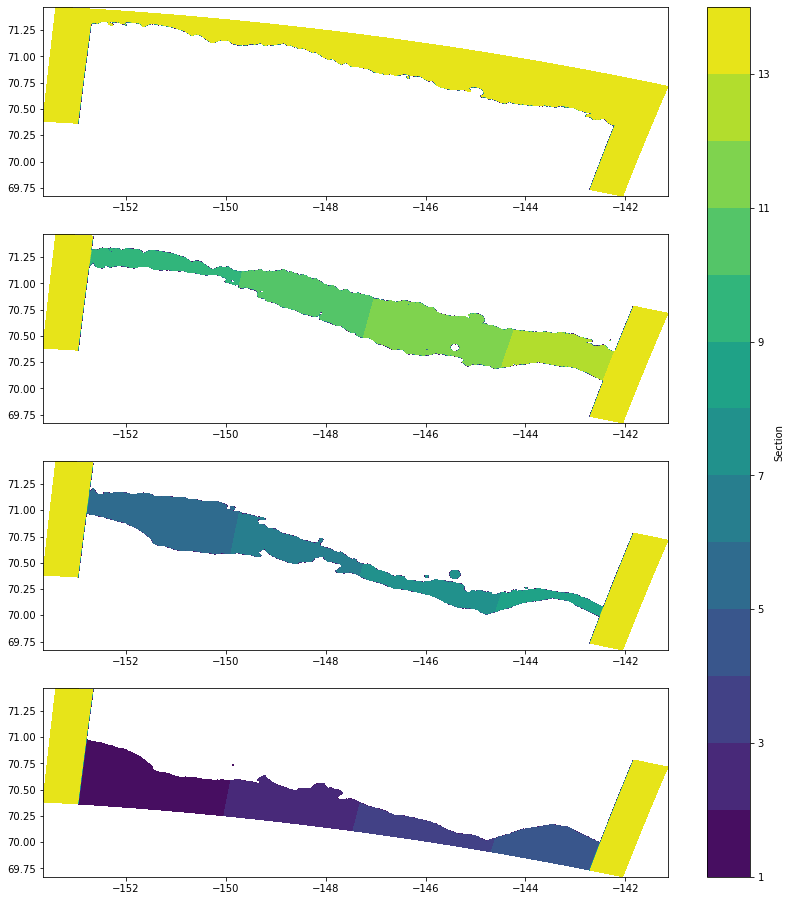

In [173]:
# Somehow plot to see if these worked...
sec_lev = np.arange(1, 15, 1)

fig, ax = plt.subplots(4, figsize=(14,16))
cs1 = ax[0].contourf(grid.lon_rho, grid.lat_rho, mask_60_end_rho_plot2, sec_lev)
cs2 = ax[1].contourf(grid.lon_rho, grid.lat_rho, mask_30_60m_rho_plot2, sec_lev)
cs3 = ax[2].contourf(grid.lon_rho, grid.lat_rho, mask_10_30m_rho_plot2, sec_lev)
cs4 = ax[3].contourf(grid.lon_rho, grid.lat_rho, mask_0_10m_rho_plot2, sec_lev)

fig.colorbar(cs1, ax=[ax[0], ax[1], ax[2], ax[3]]).set_label('Section')



In [174]:
np.where(mask_0_10m_rho_plot2 == 2)

(array([  0,   0,   0, ..., 114, 115, 115]),
 array([36, 37, 38, ..., 39, 36, 37]))

In [175]:
# Now we need to take these masks and make a new mask
# where each section has its own mask with 1s in its region
# and 0s outside of its region 
# Seabed section 1
# Make an array of zeros
seabed_sec1_mask = np.zeros_like(grid.mask_rho)
# Get the indices where it equals 2
seabed_section1_idx = np.where(mask_0_10m_rho_plot2 == 2)
# Set these areas to 1 in the mask 
seabed_sec1_mask[seabed_section1_idx] = 1

# Seabed section 2
# Make an array of zeros
seabed_sec2_mask = np.zeros_like(grid.mask_rho)
# Get the indices where it equals 3
seabed_section2_idx = np.where(mask_0_10m_rho_plot2 == 3)
# Set these areas to 1 in the other plot
seabed_sec2_mask[seabed_section2_idx] = 1

# Seabed section 3
# Make an array of zeros
seabed_sec3_mask = np.zeros_like(grid.mask_rho)
# Get the indices where it equals 4
seabed_section3_idx = np.where(mask_0_10m_rho_plot2 == 4)
# Set these areas to 1 in the other plot
seabed_sec3_mask[seabed_section3_idx] = 1

# Seabed section 4
# Make an array of zeros
seabed_sec4_mask = np.zeros_like(grid.mask_rho)
# Get the indices where it equals 5
seabed_section4_idx = np.where(mask_0_10m_rho_plot2 == 5)
# Set these areas to 1 in the other plot
seabed_sec4_mask[seabed_section4_idx] = 1

# Seabed section 5
# Make an array of zeros
seabed_sec5_mask = np.zeros_like(grid.mask_rho)
# Get the indices where it equals 6
seabed_section5_idx = np.where(mask_10_30m_rho_plot2 == 6)
# Set these areas to 1 in the other plot
seabed_sec5_mask[seabed_section5_idx] = 1

# Seabed section 6
# Make an array of zeros
seabed_sec6_mask = np.zeros_like(grid.mask_rho)
# Get the indices where it equals 7
seabed_section6_idx = np.where(mask_10_30m_rho_plot2 == 7)
# Set these areas to 1 in the other plot
seabed_sec6_mask[seabed_section6_idx] = 1

# Seabed section 7
# Make an array of zeros
seabed_sec7_mask = np.zeros_like(grid.mask_rho)
# Get the indices where it equals 8
seabed_section7_idx = np.where(mask_10_30m_rho_plot2 == 8)
# Set these areas to 1 in the other plot
seabed_sec7_mask[seabed_section7_idx] = 1

# Seabed section 8
# Make an array of zeros
seabed_sec8_mask = np.zeros_like(grid.mask_rho)
# Get the indices where it equals 9
seabed_section8_idx = np.where(mask_10_30m_rho_plot2 == 9)
# Set these areas to 1 in the other plot
seabed_sec8_mask[seabed_section8_idx] = 1

# Seabed section 9
# Make an array of zeros
seabed_sec9_mask = np.zeros_like(grid.mask_rho)
# Get the indices where it equals 10
seabed_section9_idx = np.where(mask_30_60m_rho_plot2 == 10)
# Set these areas to 1 in the other plot
seabed_sec9_mask[seabed_section9_idx] = 1

# Seabed section 10
# Make an array of zeros
seabed_sec10_mask = np.zeros_like(grid.mask_rho)
# Get the indices where it equals 11
seabed_section10_idx = np.where(mask_30_60m_rho_plot2 == 11)
# Set these areas to 1 in the other plot
seabed_sec10_mask[seabed_section10_idx] = 1

# Seabed section 11
# Make an array of zeros
seabed_sec11_mask = np.zeros_like(grid.mask_rho)
# Get the indices where it equals 12
seabed_section11_idx = np.where(mask_30_60m_rho_plot2 == 12)
# Set these areas to 1 in the other plot
seabed_sec11_mask[seabed_section11_idx] = 1

# Seabed section 12
# Make an array of zeros
seabed_sec12_mask = np.zeros_like(grid.mask_rho)
# Get the indices where it equals 13
seabed_section12_idx = np.where(mask_30_60m_rho_plot2 == 13)
# Set these areas to 1 in the other plot
seabed_sec12_mask[seabed_section12_idx] = 1

# Seabed section 13
# Make an array of zeros
seabed_sec13_mask = np.zeros_like(grid.mask_rho)
# Get the indices where it equals 14
seabed_section13_idx1 = np.where(mask_60_end_rho_plot2 == 14)
seabed_section13_idx2 = np.where(mask_30_60m_rho_plot2 == 14)
seabed_section13_idx3 = np.where(mask_10_30m_rho_plot2 == 14)
seabed_section13_idx4 = np.where(mask_0_10m_rho_plot2 == 14)
# Set these areas to 1 in the other plot
seabed_sec13_mask[seabed_section13_idx1] = 1
seabed_sec13_mask[seabed_section13_idx2] = 1
seabed_sec13_mask[seabed_section13_idx3] = 1
seabed_sec13_mask[seabed_section13_idx4] = 1


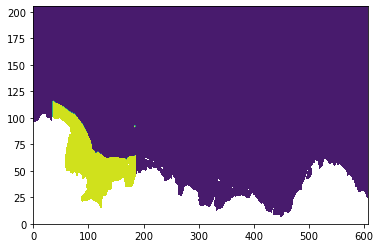

In [176]:
# Test this
plt.contourf(seabed_sec1_mask*temp_mask)

In [177]:
# Multiply each mask by its correlation
# Make a function that takes a given set of correlations 
# (values for all sections) and the masks for all 
# sections and then returns the combined map woth correlations 
# and sections for plotting 

def make_correlation_map(corr, eta_rho_len, xi_rho_len, sec1_mask, sec2_mask, sec3_mask, sec4_mask, sec5_mask,
                         sec6_mask, sec7_mask, sec8_mask, sec9_mask, sec10_mask, sec11_mask,
                         sec12_mask, sec13_mask):
    """
    This function takes the correlations for a variable in all sections and 
    makes a map that has them plotted on their section.

    Inputs:
    - corr: Pearson r correlation coefficients between given variables, shape [section]
    - sec1_mask: Mask for shelf section 1
    - sec2_mask: Mask for shelf section 2
    - sec3_mask: Mask for shelf section 3
    - sec4_mask: Mask for shelf section 4
    - sec5_mask: Mask for shelf section 5
    - sec6_mask: Mask for shelf section 6
    - sec7_mask: Mask for shelf section 7
    - sec8_mask: Mask for shelf section 8
    - sec9_mask: Mask for shelf section 9
    - sec10_mask: Mask for shelf section 10
    - sec11_mask: Mask for shelf section 11
    - sec12_mask: Mask for shelf section 12
    - sec13_mask: Mask for shelf section 13

    Outputs:
    - sec_corr_all: 2D array of the correlations spatially mapped onto their section
    """
    
    # Make a list of the masks 
    masks = [sec1_mask, sec2_mask, sec3_mask, sec4_mask, sec5_mask, sec6_mask, sec7_mask, sec8_mask,
             sec9_mask, sec10_mask, sec11_mask, sec12_mask, sec13_mask]
    masks = np.asarray(masks)

    # Make empty array to hold the maps to be added together 
    sec_corr = np.empty((len(masks), eta_rho_len, xi_rho_len))

    # Loop through the masks 
    for s in range(len(masks)):
        # Multiply each section by its correlation
        #print('corr: ', corr[s])
        #print('mask: ', masks[s])
        sec_corr[s,:,:] = corr[s]*masks[s,:,:]

    # Now add these toegether to get one map
    sec_corr_all = np.sum(sec_corr, axis=0)
    print('sec_corr_all shape: ', np.shape(sec_corr_all))

    # Return this map/added array
    return(sec_corr_all)

In [178]:
# Try calling this function and plot it to see what happens

# SSC and Hwave
ssc_hwave_agg_corr_map = make_correlation_map(r2_ssc_hwave_agg, eta_rho_len, xi_rho_len, seabed_sec1_mask, seabed_sec2_mask, seabed_sec3_mask, seabed_sec4_mask, seabed_sec5_mask,
                         seabed_sec6_mask, seabed_sec7_mask, seabed_sec8_mask, seabed_sec9_mask, seabed_sec10_mask, seabed_sec11_mask,
                         seabed_sec12_mask, seabed_sec13_mask)
ssc_hwave_unag_corr_map = make_correlation_map(r2_ssc_hwave_unag, eta_rho_len, xi_rho_len, seabed_sec1_mask, seabed_sec2_mask, seabed_sec3_mask, seabed_sec4_mask, seabed_sec5_mask,
                         seabed_sec6_mask, seabed_sec7_mask, seabed_sec8_mask, seabed_sec9_mask, seabed_sec10_mask, seabed_sec11_mask,
                         seabed_sec12_mask, seabed_sec13_mask)

# SSC and bottom current magnitude 1 m above seafloor
ssc_botcurmag_agg_corr_map = make_correlation_map(r2_ssc_botcurmag_agg, eta_rho_len, xi_rho_len, seabed_sec1_mask, seabed_sec2_mask, seabed_sec3_mask, seabed_sec4_mask, seabed_sec5_mask,
                         seabed_sec6_mask, seabed_sec7_mask, seabed_sec8_mask, seabed_sec9_mask, seabed_sec10_mask, seabed_sec11_mask,
                         seabed_sec12_mask, seabed_sec13_mask)
ssc_botcurmag_unag_corr_map = make_correlation_map(r2_ssc_botcurmag_unag, eta_rho_len, xi_rho_len, seabed_sec1_mask, seabed_sec2_mask, seabed_sec3_mask, seabed_sec4_mask, seabed_sec5_mask,
                         seabed_sec6_mask, seabed_sec7_mask, seabed_sec8_mask, seabed_sec9_mask, seabed_sec10_mask, seabed_sec11_mask,
                         seabed_sec12_mask, seabed_sec13_mask)

# SSC and bed shear stress
ssc_bstr_agg_corr_map = make_correlation_map(r2_ssc_bstr_agg, eta_rho_len, xi_rho_len, seabed_sec1_mask, seabed_sec2_mask, seabed_sec3_mask, seabed_sec4_mask, seabed_sec5_mask,
                         seabed_sec6_mask, seabed_sec7_mask, seabed_sec8_mask, seabed_sec9_mask, seabed_sec10_mask, seabed_sec11_mask,
                         seabed_sec12_mask, seabed_sec13_mask)
ssc_bstr_unag_corr_map = make_correlation_map(r2_ssc_bstr_unag, eta_rho_len, xi_rho_len, seabed_sec1_mask, seabed_sec2_mask, seabed_sec3_mask, seabed_sec4_mask, seabed_sec5_mask,
                         seabed_sec6_mask, seabed_sec7_mask, seabed_sec8_mask, seabed_sec9_mask, seabed_sec10_mask, seabed_sec11_mask,
                         seabed_sec12_mask, seabed_sec13_mask)


sec_corr_all shape:  (206, 608)
sec_corr_all shape:  (206, 608)
sec_corr_all shape:  (206, 608)
sec_corr_all shape:  (206, 608)
sec_corr_all shape:  (206, 608)
sec_corr_all shape:  (206, 608)


/Users/brun1463/opt/anaconda3/envs/xroms/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1600: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)
/Users/brun1463/opt/anaconda3/envs/xroms/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1600: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)
/Users/brun1463/opt/anaconda3/envs/xroms/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1600: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)


Text(0.84, 0.311, 'c)')

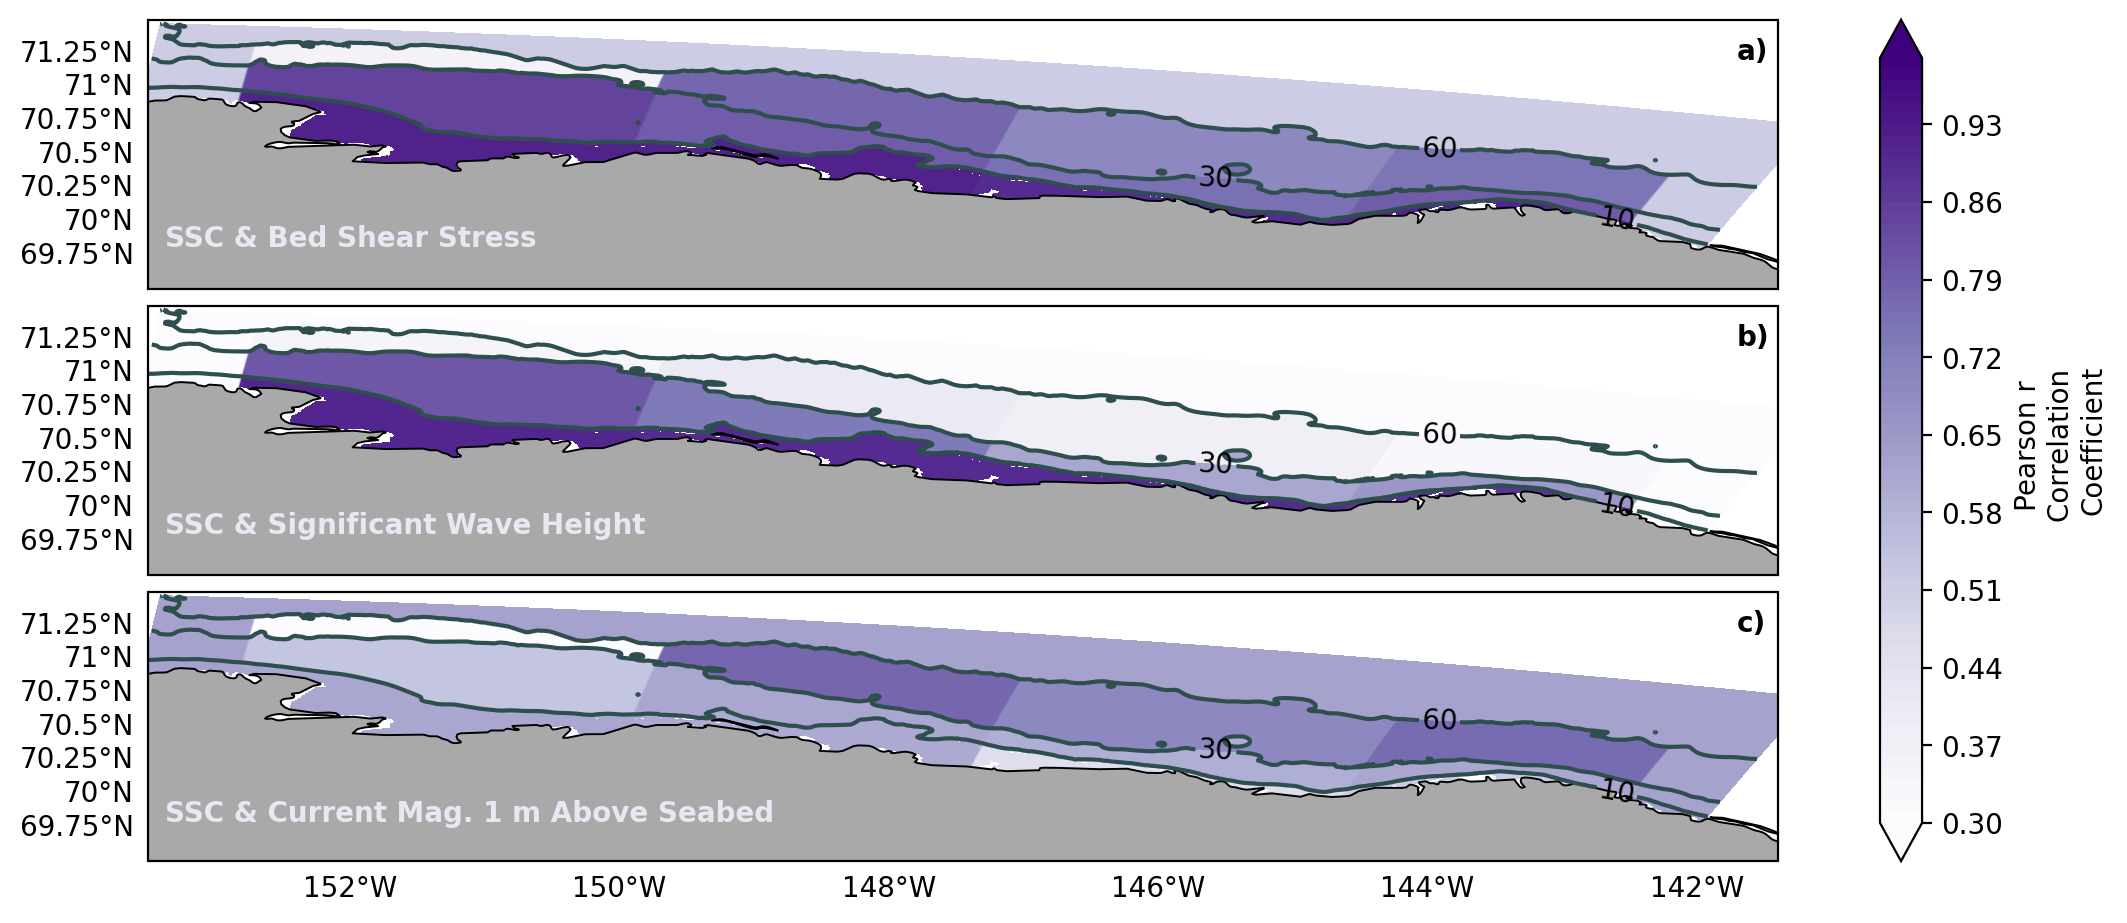

In [185]:
# Plot this to see if it worked - Aggregated 
# Set the levels 
lev_corr = np.arange(0.3, 1, 0.01)
lev_bathy = [10, 30, 60]

# Make the figure
fig, ax = plt.subplots(3, figsize=(12,4.5), dpi=200,
                       constrained_layout=True, 
                       subplot_kw={'projection': crs})

# SSC and bed shear stress
cs1 = ax[0].contourf(grid.lon_rho, grid.lat_rho, ssc_bstr_agg_corr_map*temp_mask, lev_corr, cmap='Purples',
                  transform=ccrs.PlateCarree(), extend='both')

# SSC and Hwave
cs2 = ax[1].contourf(grid.lon_rho, grid.lat_rho, ssc_hwave_agg_corr_map*temp_mask, lev_corr, cmap='Purples',
                  transform=ccrs.PlateCarree(), extend='both')

# SSC and bottom current 1 m above seafloor
cs3 = ax[2].contourf(grid.lon_rho, grid.lat_rho, ssc_botcurmag_agg_corr_map*temp_mask, lev_corr, cmap='Purples',
                  transform=ccrs.PlateCarree(), extend='both')

# Loop through axes to add features
for r in range(3):
    # Plot bathymetry 
    c1 = ax[r].contour(grid.lon_rho, grid.lat_rho, grid.h, lev_bathy, colors='darkslategrey', linewidth=2)
    ax[r].clabel(c1, inline=True, fontsize=10, colors='black')

    # Set extent and map features
    ax[r].set_extent([-153.5,-141.4,69.5, 71.5],ccrs.PlateCarree())
    # ax.set_aspect(lat_rad)
    ax[r].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                                facecolor='darkgray'), linewidth=.7)
    ax[r].coastlines(resolution='10m', linewidth=.7)

    gl = ax[r].gridlines(crs=ccrs.PlateCarree(), 
                      draw_labels=True, 
                      x_inline=False, y_inline=False, 
                      linewidth=0, color='k',alpha=0.5)
    gl.right_labels = gl.top_labels = False
    if r == 2:
        gl.bottom_labels = True
    else:
        gl.bottom_labels = False
    gl.xlocator = ticker.FixedLocator([-152, -150,-148,-146,-144,-142])
    gl.xlabel_style = {'rotation': 0, 'ha': 'center'}

fig.colorbar(cs1, ax=[ax[0], ax[1], ax[2]], extend='both').set_label('Pearson r \nCorrelation \nCoefficient')

# Add text explaining what each plot is 
fig.text(0.185, 0.739, 'SSC & Bed Shear Stress', color='#E9E7F2', fontweight='bold') # fontweight='bold', fontsize=fontsize
fig.text(0.185, 0.420, 'SSC & Significant Wave Height', color='#E9E7F2', fontweight='bold') # fontweight='bold', fontsize=fontsize
fig.text(0.185, 0.100, 'SSC & Current Mag. 1 m Above Seabed', color='#E9E7F2', fontweight='bold') # fontweight='bold', fontsize=fontsize

# Add subplot labels
fig.text(0.840, 0.946, 'a)', fontweight='bold') # fontweight='bold', fontsize=fontsize
fig.text(0.840, 0.629, 'b)', fontweight='bold') # fontweight='bold', fontsize=fontsize
fig.text(0.840, 0.311, 'c)', fontweight='bold') # fontweight='bold', fontsize=fontsize

#

/Users/brun1463/opt/anaconda3/envs/xroms/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1600: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)
/Users/brun1463/opt/anaconda3/envs/xroms/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1600: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)
/Users/brun1463/opt/anaconda3/envs/xroms/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1600: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)


Text(0.84, 0.311, 'c)')

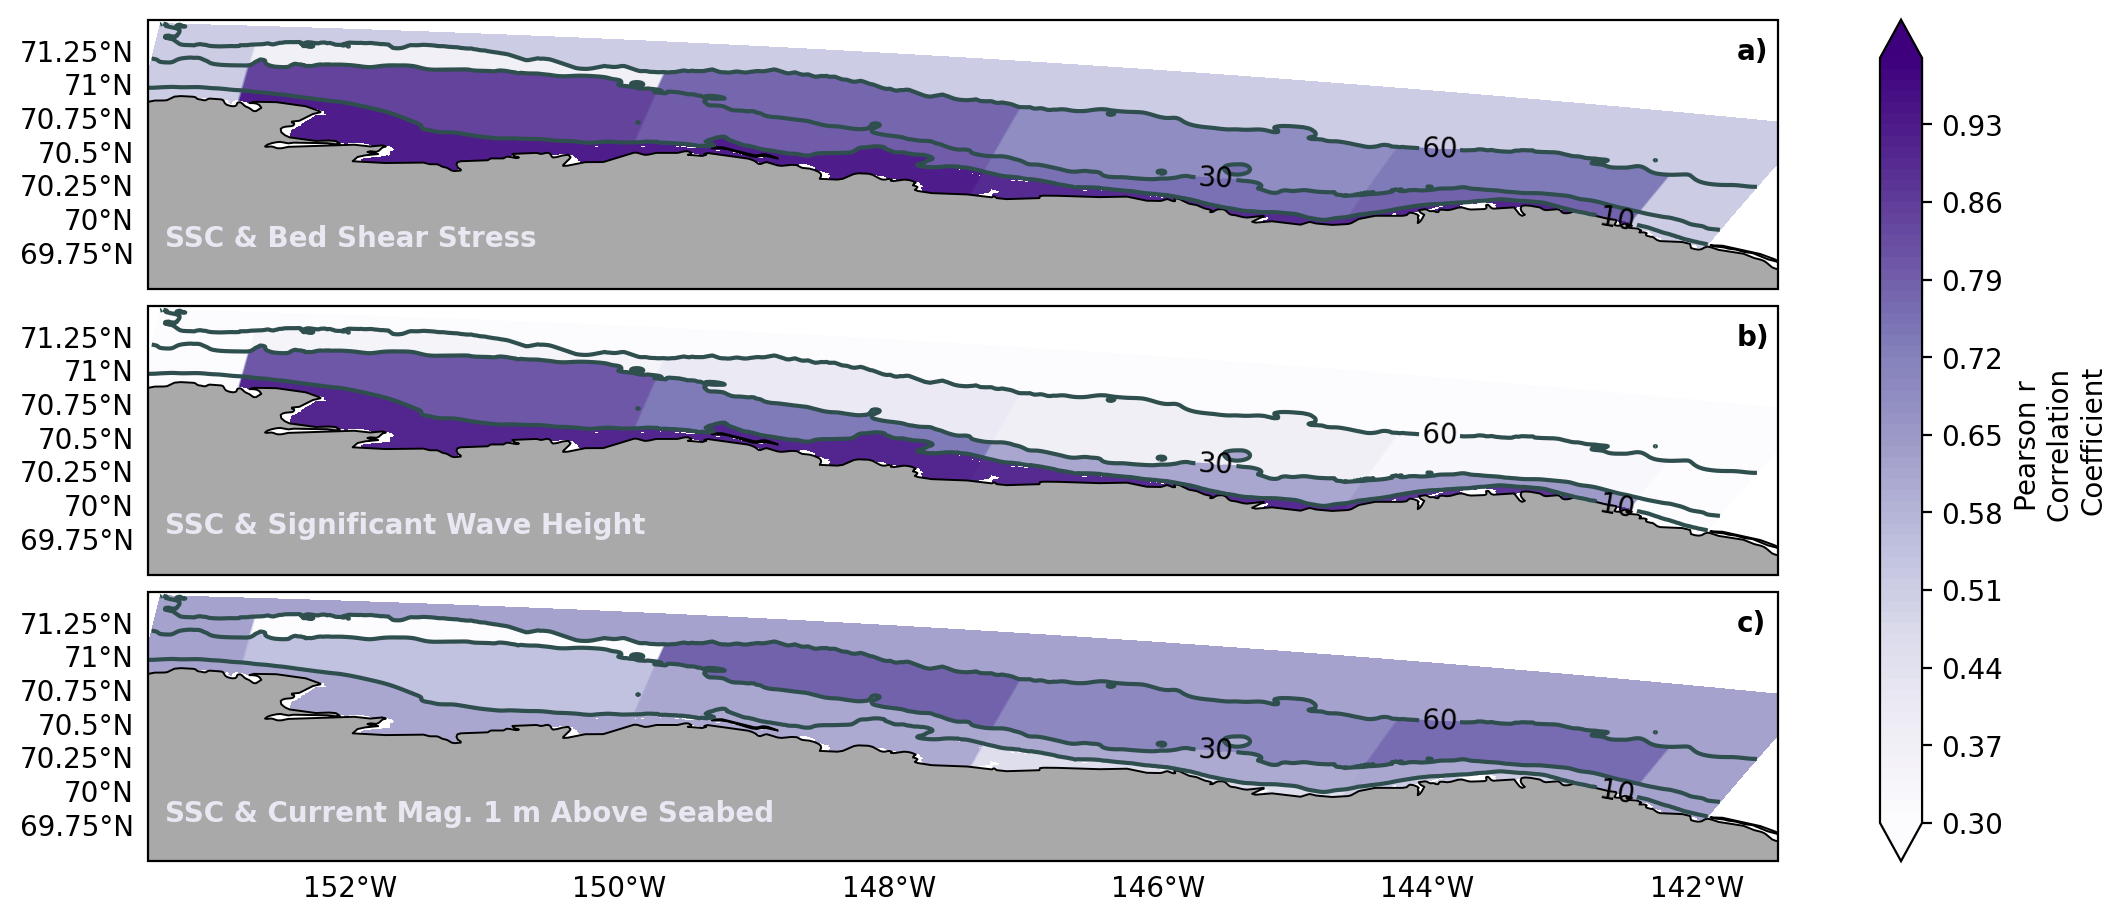

In [186]:
# Make same plot but unaggregated
# Set the levels 
lev_corr = np.arange(0.3, 1, 0.01)
lev_bathy = [10, 30, 60]

# Make the figure
fig, ax = plt.subplots(3, figsize=(12,4.5), dpi=200,
                       constrained_layout=True, 
                       subplot_kw={'projection': crs})

# SSC and bed shear stress
cs1 = ax[0].contourf(grid.lon_rho, grid.lat_rho, ssc_bstr_unag_corr_map*temp_mask, lev_corr, cmap='Purples',
                  transform=ccrs.PlateCarree(), extend='both')

# SSC and Hwave
cs2 = ax[1].contourf(grid.lon_rho, grid.lat_rho, ssc_hwave_unag_corr_map*temp_mask, lev_corr, cmap='Purples',
                  transform=ccrs.PlateCarree(), extend='both')

# SSC and bottom current 1 m above seafloor
cs3 = ax[2].contourf(grid.lon_rho, grid.lat_rho, ssc_botcurmag_unag_corr_map*temp_mask, lev_corr, cmap='Purples',
                  transform=ccrs.PlateCarree(), extend='both')

# Loop through axes to add features
for r in range(3):
    # Plot bathymetry 
    c1 = ax[r].contour(grid.lon_rho, grid.lat_rho, grid.h, lev_bathy, colors='darkslategrey', linewidth=2)
    ax[r].clabel(c1, inline=True, fontsize=10, colors='black')
    
    # Set extent and map features
    ax[r].set_extent([-153.5,-141.4,69.5, 71.5],ccrs.PlateCarree())
    # ax.set_aspect(lat_rad)
    ax[r].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                                facecolor='darkgray'), linewidth=.7)
    ax[r].coastlines(resolution='10m', linewidth=.7)

    gl = ax[r].gridlines(crs=ccrs.PlateCarree(), 
                      draw_labels=True, 
                      x_inline=False, y_inline=False, 
                      linewidth=0, color='k',alpha=0.5)
    gl.right_labels = gl.top_labels = False
    if r == 2:
        gl.bottom_labels = True
    else:
        gl.bottom_labels = False
    gl.xlocator = ticker.FixedLocator([-152, -150,-148,-146,-144,-142])
    gl.xlabel_style = {'rotation': 0, 'ha': 'center'}

fig.colorbar(cs1, ax=[ax[0], ax[1], ax[2]], extend='both').set_label('Pearson r \nCorrelation \nCoefficient')

# Add text explaining what each plot is 
fig.text(0.185, 0.739, 'SSC & Bed Shear Stress', color='#E9E7F2', fontweight='bold') # fontweight='bold', fontsize=fontsize
fig.text(0.185, 0.420, 'SSC & Significant Wave Height', color='#E9E7F2', fontweight='bold') # fontweight='bold', fontsize=fontsize
fig.text(0.185, 0.100, 'SSC & Current Mag. 1 m Above Seabed', color='#E9E7F2', fontweight='bold') # fontweight='bold', fontsize=fontsize

# Add subplot labels
fig.text(0.840, 0.946, 'a)', fontweight='bold') # fontweight='bold', fontsize=fontsize
fig.text(0.840, 0.629, 'b)', fontweight='bold') # fontweight='bold', fontsize=fontsize
fig.text(0.840, 0.311, 'c)', fontweight='bold') # fontweight='bold', fontsize=fontsize

In [181]:
mask_rho_nan.nudge_mask_rho_nan

<xarray.DataArray 'nudge_mask_rho_nan' (eta_rho: 206, xi_rho: 608)>
[125248 values with dtype=float64]
Coordinates:
  * eta_rho  (eta_rho) float64 0.0 1.0 2.0 3.0 4.0 ... 202.0 203.0 204.0 205.0
  * xi_rho   (xi_rho) float64 0.0 1.0 2.0 3.0 4.0 ... 604.0 605.0 606.0 607.0

/Users/brun1463/opt/anaconda3/envs/xroms/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1600: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)
/Users/brun1463/opt/anaconda3/envs/xroms/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1600: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)
/Users/brun1463/opt/anaconda3/envs/xroms/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1600: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)


Text(0.84, 0.311, 'c)')

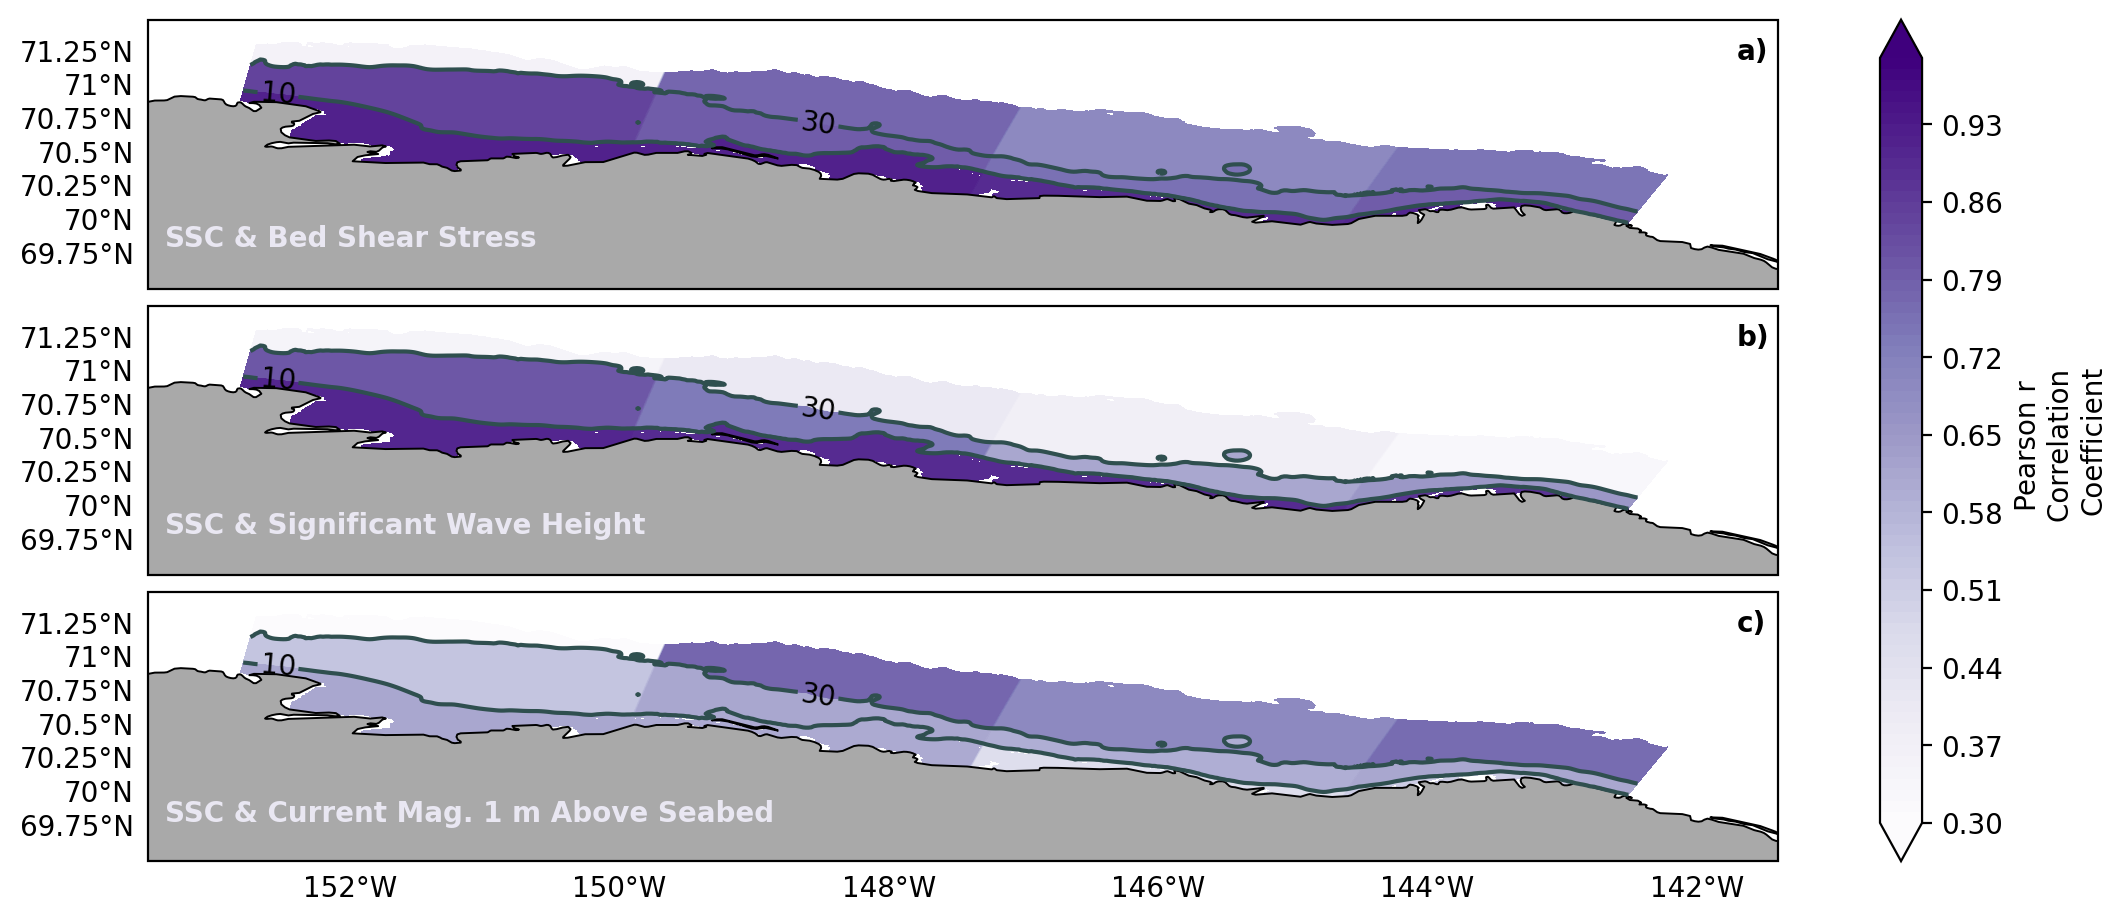

In [187]:
# Plot again but exclude section 13 - aggreated
# Set the levels 
lev_corr = np.arange(0.3, 1, 0.01)
lev_bathy = [10, 30, 60]

# Make the figure
fig, ax = plt.subplots(3, figsize=(12,4.5), dpi=200,
                       constrained_layout=True, 
                       subplot_kw={'projection': crs})

# SSC and bed shear stress
cs1 = ax[0].contourf(grid.lon_rho, grid.lat_rho, ssc_bstr_agg_corr_map*temp_mask*mask_rho_nan.nudge_mask_rho_nan, lev_corr, cmap='Purples',
                  transform=ccrs.PlateCarree(), extend='both')

# SSC and Hwave
cs2 = ax[1].contourf(grid.lon_rho, grid.lat_rho, ssc_hwave_agg_corr_map*temp_mask*mask_rho_nan.nudge_mask_rho_nan, lev_corr, cmap='Purples',
                  transform=ccrs.PlateCarree(), extend='both')

# SSC and bottom current 1 m above seafloor
cs3 = ax[2].contourf(grid.lon_rho, grid.lat_rho, ssc_botcurmag_agg_corr_map*temp_mask*mask_rho_nan.nudge_mask_rho_nan, lev_corr, cmap='Purples',
                  transform=ccrs.PlateCarree(), extend='both')

# Loop through axes to add features
for r in range(3):
    # Plot bathymetry 
    c1 = ax[r].contour(grid.lon_rho, grid.lat_rho, grid.h*mask_rho_nan.nudge_mask_rho_nan, lev_bathy, colors='darkslategrey', linewidth=2)
    ax[r].clabel(c1, inline=True, fontsize=10, colors='black')
    
    # Set extent and map features
    ax[r].set_extent([-153.5,-141.4,69.5, 71.5],ccrs.PlateCarree())
    # ax.set_aspect(lat_rad)
    ax[r].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                                facecolor='darkgray'), linewidth=.7)
    ax[r].coastlines(resolution='10m', linewidth=.7)

    gl = ax[r].gridlines(crs=ccrs.PlateCarree(), 
                      draw_labels=True, 
                      x_inline=False, y_inline=False, 
                      linewidth=0, color='k',alpha=0.5)
    gl.right_labels = gl.top_labels = False
    if r == 2:
        gl.bottom_labels = True
    else:
        gl.bottom_labels = False
    gl.xlocator = ticker.FixedLocator([-152, -150,-148,-146,-144,-142])
    gl.xlabel_style = {'rotation': 0, 'ha': 'center'}

fig.colorbar(cs1, ax=[ax[0], ax[1], ax[2]], extend='both').set_label('Pearson r \nCorrelation \nCoefficient')

# Add text explaining what each plot is 
fig.text(0.185, 0.739, 'SSC & Bed Shear Stress', color='#E9E7F2', fontweight='bold') # fontweight='bold', fontsize=fontsize
fig.text(0.185, 0.420, 'SSC & Significant Wave Height', color='#E9E7F2', fontweight='bold') # fontweight='bold', fontsize=fontsize
fig.text(0.185, 0.100, 'SSC & Current Mag. 1 m Above Seabed', color='#E9E7F2', fontweight='bold') # fontweight='bold', fontsize=fontsize

# Add subplot labels
fig.text(0.840, 0.946, 'a)', fontweight='bold') # fontweight='bold', fontsize=fontsize
fig.text(0.840, 0.629, 'b)', fontweight='bold') # fontweight='bold', fontsize=fontsize
fig.text(0.840, 0.311, 'c)', fontweight='bold') # fontweight='bold', fontsize=fontsize

/Users/brun1463/opt/anaconda3/envs/xroms/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1600: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)
/Users/brun1463/opt/anaconda3/envs/xroms/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1600: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)
/Users/brun1463/opt/anaconda3/envs/xroms/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1600: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)


Text(0.76, 0.312, 'c)')

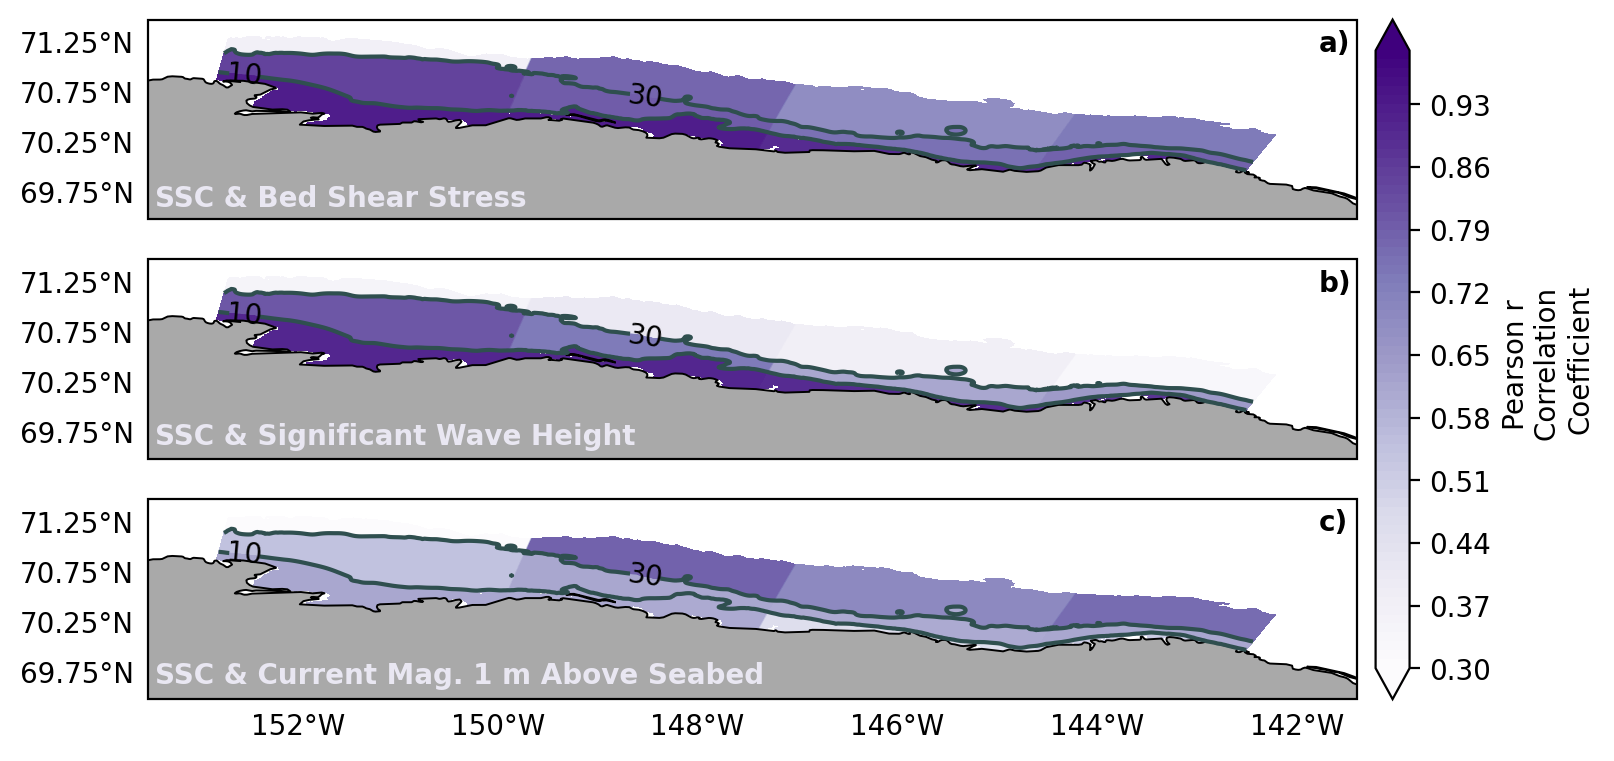

In [228]:
# Plot again but exclude section 13 - unaggreated
# Set the levels 
lev_corr = np.arange(0.3, 1, 0.01)
lev_bathy = [10, 30, 60]

# Make the figure
fig, ax = plt.subplots(3, figsize=(12,4.5), dpi=200,
                       #constrained_layout=True, 
                       subplot_kw={'projection': crs})

# SSC and bed shear stress
cs1 = ax[0].contourf(grid.lon_rho, grid.lat_rho, ssc_bstr_unag_corr_map*temp_mask*mask_rho_nan.nudge_mask_rho_nan, lev_corr, cmap='Purples',
                  transform=ccrs.PlateCarree(), extend='both')

# SSC and Hwave
cs2 = ax[1].contourf(grid.lon_rho, grid.lat_rho, ssc_hwave_unag_corr_map*temp_mask*mask_rho_nan.nudge_mask_rho_nan, lev_corr, cmap='Purples',
                  transform=ccrs.PlateCarree(), extend='both')

# SSC and bottom current 1 m above seafloor
cs3 = ax[2].contourf(grid.lon_rho, grid.lat_rho, ssc_botcurmag_unag_corr_map*temp_mask*mask_rho_nan.nudge_mask_rho_nan, lev_corr, cmap='Purples',
                  transform=ccrs.PlateCarree(), extend='both')

# Loop through axes to add features
for r in range(3):
    # Plot bathymetry 
    c1 = ax[r].contour(grid.lon_rho, grid.lat_rho, grid.h*mask_rho_nan.nudge_mask_rho_nan, lev_bathy, colors='darkslategrey', linewidth=2)
    ax[r].clabel(c1, inline=True, fontsize=10, colors='black')
    
    # Set extent and map features
    ax[r].set_extent([-153.5,-141.4,69.5, 71.5],ccrs.PlateCarree())
    # ax.set_aspect(lat_rad)
    ax[r].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                                facecolor='darkgray'), linewidth=.7)
    ax[r].coastlines(resolution='10m', linewidth=.7)

    gl = ax[r].gridlines(crs=ccrs.PlateCarree(), 
                      draw_labels=True, 
                      x_inline=False, y_inline=False, 
                      linewidth=0, color='k',alpha=0.5)
    gl.right_labels = gl.top_labels = False
    if r == 2:
        gl.bottom_labels = True
    else:
        gl.bottom_labels = False
    gl.xlocator = ticker.FixedLocator([-152, -150,-148,-146,-144,-142])
    gl.xlabel_style = {'rotation': 0, 'ha': 'center'}

fig.colorbar(cs1, ax=[ax[0], ax[1], ax[2]], extend='both', pad=0.01).set_label('Pearson r \nCorrelation \nCoefficient')

# Add text explaining what each plot is 
fig.text(0.275, 0.672, 'SSC & Bed Shear Stress', color='#E9E7F2', fontweight='bold') # fontweight='bold', fontsize=fontsize
fig.text(0.275, 0.408, 'SSC & Significant Wave Height', color='#E9E7F2', fontweight='bold') # fontweight='bold', fontsize=fontsize
fig.text(0.275, 0.142, 'SSC & Current Mag. 1 m Above Seabed', color='#E9E7F2', fontweight='bold') # fontweight='bold', fontsize=fontsize

# Add subplot labels
fig.text(0.760, 0.844, 'a)', fontweight='bold') # fontweight='bold', fontsize=fontsize
fig.text(0.760, 0.578, 'b)', fontweight='bold') # fontweight='bold', fontsize=fontsize
fig.text(0.760, 0.312, 'c)', fontweight='bold') # fontweight='bold', fontsize=fontsize

/Users/brun1463/opt/anaconda3/envs/xroms/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1600: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)
/Users/brun1463/opt/anaconda3/envs/xroms/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1600: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)
/Users/brun1463/opt/anaconda3/envs/xroms/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1600: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)


Text(0.76, 0.312, 'c)')

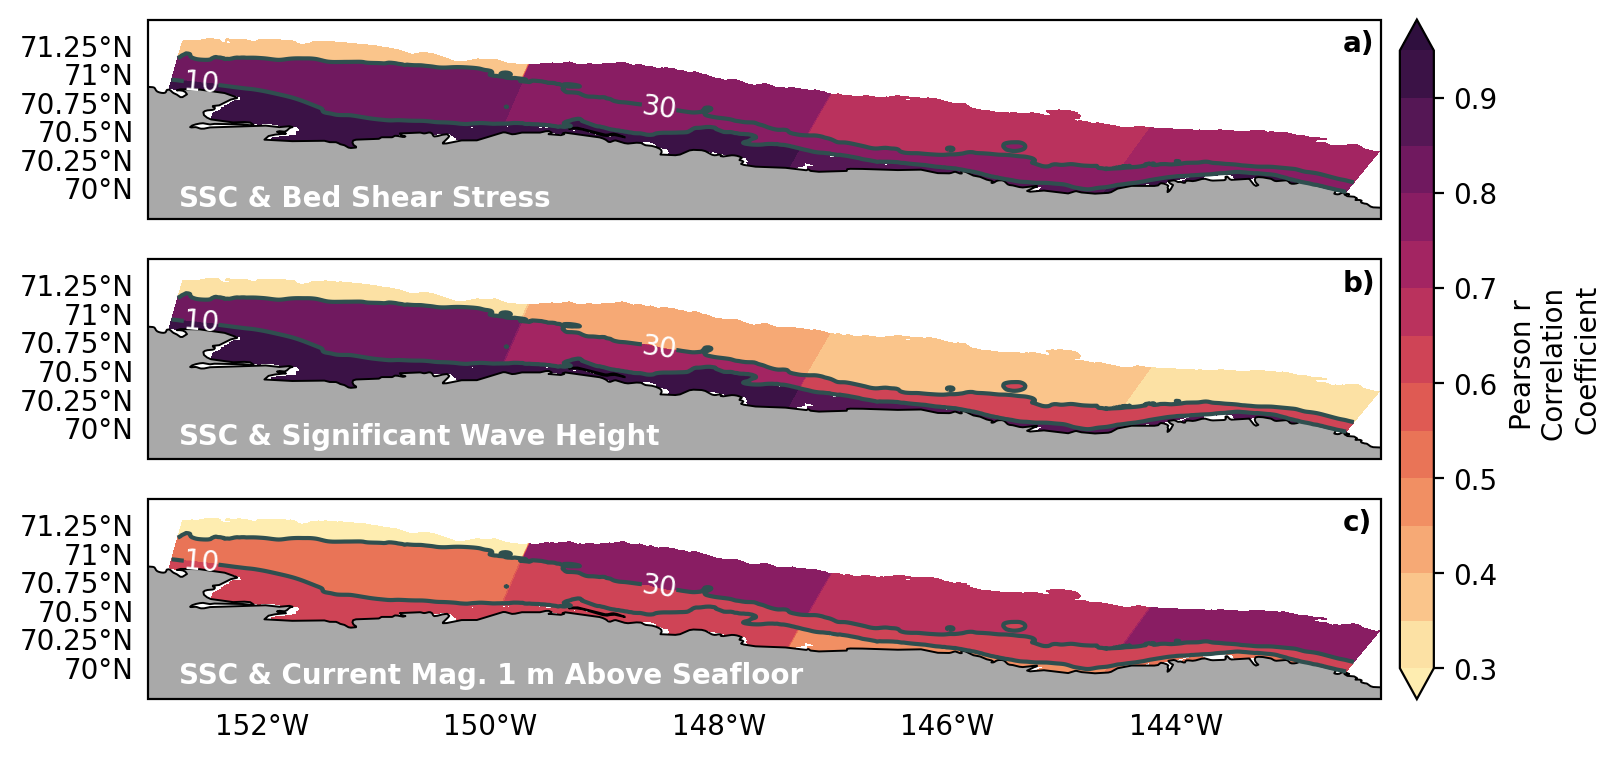

In [239]:
# Plot again but exclude section 13 - unaggreated
# And add text for the correlations onto the plots

# Set the levels 
lev_corr = np.arange(0.3, 1, 0.05)
lev_bathy = [10, 30, 60]

# Make the figure
fig, ax = plt.subplots(3, figsize=(12,4.5), dpi=200,
                       #constrained_layout=True, 
                       subplot_kw={'projection': crs})

# SSC and bed shear stress
cs1 = ax[0].contourf(grid.lon_rho, grid.lat_rho, ssc_bstr_unag_corr_map*temp_mask*mask_rho_nan.nudge_mask_rho_nan, lev_corr, cmap=cmocean.cm.matter, #'Purples'
                  transform=ccrs.PlateCarree(), extend='both')

# SSC and Hwave
cs2 = ax[1].contourf(grid.lon_rho, grid.lat_rho, ssc_hwave_unag_corr_map*temp_mask*mask_rho_nan.nudge_mask_rho_nan, lev_corr, cmap=cmocean.cm.matter,
                  transform=ccrs.PlateCarree(), extend='both')

# SSC and bottom current 1 m above seafloor
cs3 = ax[2].contourf(grid.lon_rho, grid.lat_rho, ssc_botcurmag_unag_corr_map*temp_mask*mask_rho_nan.nudge_mask_rho_nan, lev_corr, cmap=cmocean.cm.matter,
                  transform=ccrs.PlateCarree(), extend='both')

# Loop through axes to add features
for r in range(3):
    # Plot bathymetry 
    c1 = ax[r].contour(grid.lon_rho, grid.lat_rho, grid.h*mask_rho_nan.nudge_mask_rho_nan, lev_bathy, colors='darkslategrey', linewidth=2)
    ax[r].clabel(c1, inline=True, fontsize=10, colors='white')
    
    # Set extent and map features
    #ax[r].set_extent([-153.5,-141.4,69.5, 71.5],ccrs.PlateCarree())
    ax[r].set_extent([-153,-142.2,69.75, 71.5],ccrs.PlateCarree())
    # ax.set_aspect(lat_rad)
    ax[r].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                                facecolor='darkgray'), linewidth=.7)
    ax[r].coastlines(resolution='10m', linewidth=.7)

    gl = ax[r].gridlines(crs=ccrs.PlateCarree(), 
                      draw_labels=True, 
                      x_inline=False, y_inline=False, 
                      linewidth=0, color='k',alpha=0.5)
    gl.right_labels = gl.top_labels = False
    if r == 2:
        gl.bottom_labels = True
    else:
        gl.bottom_labels = False
    gl.xlocator = ticker.FixedLocator([-152, -150,-148,-146,-144,-142])
    gl.xlabel_style = {'rotation': 0, 'ha': 'center'}

fig.colorbar(cs1, ax=[ax[0], ax[1], ax[2]], extend='both', pad=0.01).set_label('Pearson r \nCorrelation \nCoefficient')

# Add text explaining what each plot is 
fig.text(0.275, 0.672, 'SSC & Bed Shear Stress', color='white', fontweight='bold') # fontweight='bold', fontsize=fontsize
fig.text(0.275, 0.408, 'SSC & Significant Wave Height', color='white', fontweight='bold') # fontweight='bold', fontsize=fontsize
fig.text(0.275, 0.142, 'SSC & Current Mag. 1 m Above Seafloor', color='white', fontweight='bold') # fontweight='bold', fontsize=fontsize, E9E7F2

# Add subplot labels
fig.text(0.760, 0.844, 'a)', fontweight='bold') # fontweight='bold', fontsize=fontsize
fig.text(0.760, 0.578, 'b)', fontweight='bold') # fontweight='bold', fontsize=fontsize
fig.text(0.760, 0.312, 'c)', fontweight='bold') # fontweight='bold', fontsize=fontsize

In [184]:
# Compare with the line plot to see if the values look correct 
# Waves need to be fixed once time is fixed but the general idea is there!